# Naive k-means clustering on the color values to see if it highlights the color breakpoint

### imports

In [1]:
import pandas as pd
import geopandas as gpd, rasterio, numpy as np
from rasterio.transform import from_origin
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, box, Polygon
from matplotlib_scalebar.scalebar import ScaleBar
from pyproj import Transformer
import cv2

### load the data

In [2]:
color_df = pd.read_csv('../datasets/1-clusters/cluster1.csv')
color_df_reduced = (
    color_df.groupby("gbifID", sort=False, group_keys=False)
    .apply(lambda x: x.sample(1))
    .reset_index(drop=True)
)
color_df_reduced

/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_85359/931606744.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1))


,image_idx,hex,rgb,hsl,lab,gbifID,identifier,latitude,longitude
0,0,#d4b4de,"(212, 180, 222)","(0.7936507936507936, 0.38888888888888895, 0.78...","(197, 147, 111)",923911394,https://inaturalist-open-data.s3.amazonaws.com...,48.826305,-102.092171
1,2,#cdb2cb,"(205, 178, 203)","(0.8456790123456791, 0.21259842519685052, 0.75...","(193, 142, 119)",923910407,https://inaturalist-open-data.s3.amazonaws.com...,43.613086,-73.057076
2,4,#bba6d7,"(187, 166, 215)","(0.738095238095238, 0.3798449612403101, 0.7470...","(182, 145, 106)",899970365,https://inaturalist-open-data.s3.amazonaws.com...,43.066871,-87.890565
3,7,#9984ae,"(153, 132, 174)","(0.75, 0.2058823529411765, 0.6000000000000001)","(149, 144, 109)",891778924,https://inaturalist-open-data.s3.amazonaws.com...,42.140556,-87.831643
4,9,#ba9edb,"(186, 158, 219)","(0.7431693989071038, 0.4586466165413533, 0.739...","(177, 150, 101)",891760719,https://inaturalist-open-data.s3.amazonaws.com...,38.679240,-97.990035
...,...,...,...,...,...,...,...,...,...
16582,41059,#9f8fc0,"(159, 143, 192)","(0.7210884353741497, 0.27999999999999997, 0.65...","(159, 144, 105)",1024218211,https://inaturalist-open-data.s3.amazonaws.com...,41.569419,-88.150552
16583,41060,#b47eb0,"(180, 126, 176)","(0.845679012345679, 0.2647058823529413, 0.6000...","(152, 157, 110)",1024202810,https://inaturalist-open-data.s3.amazonaws.com...,45.057871,-87.168277
16584,41061,#ae95c8,"(174, 149, 200)","(0.7483660130718954, 0.31677018633540366, 0.68...","(167, 147, 105)",1024200169,https://inaturalist-open-data.s3.amazonaws.com...,42.921738,-88.026752
16585,41063,#c8b9b1,"(200, 185, 177)","(0.057971014492753624, 0.17293233082706772, 0....","(194, 132, 134)",1024198670,https://inaturalist-open-data.s3.amazonaws.com...,40.791723,-80.492498


# K-means clustering into two groups

In [3]:
L = [(int(i.strip('()').split(', ')[0])) for i in color_df_reduced.lab]
L = (np.array(L) / 255.0) * 100.0  
color_df_reduced['L'] = L
a = [(int(i.strip('()').split(', ')[1])) for i in color_df_reduced.lab]
a = np.array(a) - 128.0  
color_df_reduced['a'] = a
b = [(int(i.strip('()').split(', ')[2])) for i in color_df_reduced.lab]
b = np.array(b) - 128.0
color_df_reduced['b'] = b

In [4]:
#X = color_df_reduced[['longitude','latitude','darkness']]
X = color_df_reduced[['L','a','b']]
Xs = StandardScaler().fit_transform(X)

km = KMeans(n_clusters=2, random_state=0,max_iter=3000,tol=0.000001).fit(Xs)
color_df_reduced['cluster'] = km.labels_
color_df_reduced

,image_idx,hex,rgb,hsl,lab,gbifID,identifier,latitude,longitude,L,a,b,cluster
0,0,#d4b4de,"(212, 180, 222)","(0.7936507936507936, 0.38888888888888895, 0.78...","(197, 147, 111)",923911394,https://inaturalist-open-data.s3.amazonaws.com...,48.826305,-102.092171,77.254902,19.0,-17.0,0
1,2,#cdb2cb,"(205, 178, 203)","(0.8456790123456791, 0.21259842519685052, 0.75...","(193, 142, 119)",923910407,https://inaturalist-open-data.s3.amazonaws.com...,43.613086,-73.057076,75.686275,14.0,-9.0,0
2,4,#bba6d7,"(187, 166, 215)","(0.738095238095238, 0.3798449612403101, 0.7470...","(182, 145, 106)",899970365,https://inaturalist-open-data.s3.amazonaws.com...,43.066871,-87.890565,71.372549,17.0,-22.0,0
3,7,#9984ae,"(153, 132, 174)","(0.75, 0.2058823529411765, 0.6000000000000001)","(149, 144, 109)",891778924,https://inaturalist-open-data.s3.amazonaws.com...,42.140556,-87.831643,58.431373,16.0,-19.0,1
4,9,#ba9edb,"(186, 158, 219)","(0.7431693989071038, 0.4586466165413533, 0.739...","(177, 150, 101)",891760719,https://inaturalist-open-data.s3.amazonaws.com...,38.679240,-97.990035,69.411765,22.0,-27.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16582,41059,#9f8fc0,"(159, 143, 192)","(0.7210884353741497, 0.27999999999999997, 0.65...","(159, 144, 105)",1024218211,https://inaturalist-open-data.s3.amazonaws.com...,41.569419,-88.150552,62.352941,16.0,-23.0,1
16583,41060,#b47eb0,"(180, 126, 176)","(0.845679012345679, 0.2647058823529413, 0.6000...","(152, 157, 110)",1024202810,https://inaturalist-open-data.s3.amazonaws.com...,45.057871,-87.168277,59.607843,29.0,-18.0,1
16584,41061,#ae95c8,"(174, 149, 200)","(0.7483660130718954, 0.31677018633540366, 0.68...","(167, 147, 105)",1024200169,https://inaturalist-open-data.s3.amazonaws.com...,42.921738,-88.026752,65.490196,19.0,-23.0,1
16585,41063,#c8b9b1,"(200, 185, 177)","(0.057971014492753624, 0.17293233082706772, 0....","(194, 132, 134)",1024198670,https://inaturalist-open-data.s3.amazonaws.com...,40.791723,-80.492498,76.078431,4.0,6.0,0


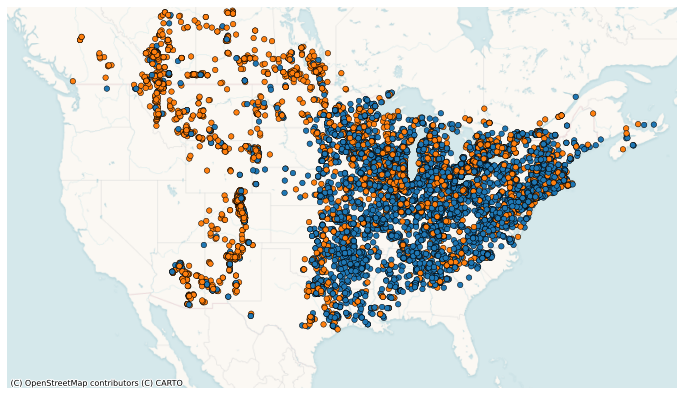

In [5]:
# bounds in lat/lon EPSG:4326
# start here bc uses wgs84 and good for real world data
min_lon, min_lat, max_lon, max_lat = -130, 24, -59, 54  # adjust as needed

# make the bounding box geo
bbox = box(min_lon, min_lat, max_lon, max_lat)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs="EPSG:4326")

# convert to web mercator EPSG:3857 bc better for mapping
bbox_gdf = bbox_gdf.to_crs(epsg=3857)
xmin, ymin, xmax, ymax = bbox_gdf.total_bounds

# get geodataframe of points, again starting w 4326 and converting
gdf = gpd.GeoDataFrame(color_df_reduced, geometry=[Point(xy) for xy in zip(color_df_reduced.longitude, color_df_reduced.latitude)], crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)

# define your palette
cluster_colors = {
    0: '#1f77b4',  # blue
    1: '#ff7f0e',  # orange
}

# add a new column for plotting
gdf['cluster_color'] = gdf['cluster'].map(cluster_colors)

fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(
    gdf.geometry.x,
    gdf.geometry.y,
    c=gdf['cluster_color'],
    s=30,
    alpha=1,
    edgecolors='k',
    linewidths=0.5
)

# manual legend
for cluster, color in cluster_colors.items():
    ax.scatter([], [], c=color, label=f'Cluster {cluster}', s=150, edgecolors='k')
#ax.legend(title='Cluster')

# basemap & clean up
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels)
ax.set_axis_off()

plt.savefig('../figures/figure_puzzling/kmeans_scatter.pdf',dpi=300)

plt.show()

# Look at average cluster value in each longitudinal window
### (Orange dots: cluster=1, Blue dots: cluster=0)

In [6]:
lons = []
means=[]
for lon in np.linspace(color_df_reduced.longitude.min()+1, color_df_reduced.longitude.max()-1,1000):
    subdf = color_df_reduced[(color_df_reduced.longitude > (lon-2)) & (color_df_reduced.longitude < (lon+2))]
    if len(subdf) > 25: # if there are at least 25 observations in the window...
        lons.append(lon)
        means.append(subdf.cluster.mean()) # average the cluster value

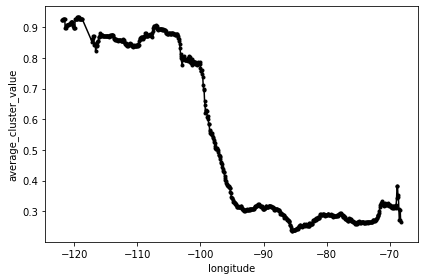

In [7]:
plt.plot(lons, means, marker='o', ms=3,c='black')
plt.xlabel('longitude')
plt.ylabel('average_cluster_value')
plt.tight_layout()
plt.savefig('../figures/figure_puzzling/kmeans_average_longitudes.pdf',dpi=300)
plt.show()